In [4]:
import pandas as pd
import numpy as np
from sklearn import linear_model, preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler
import xgboost
from sklearn.decomposition import PCA
import warnings
import random
import time
import os
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Ignore FutureWarnings and SettingWithCopyWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn.neural_network")

pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
def scale_columns(df, name, columns_to_scale=True):
    scaler = StandardScaler()
    df_scaled = df.copy()
    if columns_to_scale:
        df_scaled[['last_fitness_binary_percentage_scaled', 'change_fitness_binary_percentage_scaled']] = scaler.fit_transform(df[['last_fitness_binary_percentage', 'change_fitness_binary_percentage']])
    df_scaled['dataset'] = name
    return df_scaled

def generate_heatmap(df, values, title):
    # Create the pivot table using pivot_table function
    pivot_df = df.pivot_table(index='learning_strategy', columns='regression_type', values=values, aggfunc=np.max)

    # Plotting the heatmap with square boxes and color scale from 0 to 1
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt=".2f", square=True, vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel('Regression Type')
    plt.ylabel('Learning Strategy')
    plt.show()

def perform_feature_importance(df, target_variable, title, quantitative_variables = False, subset = None):

    # Drop the columns that are not needed for analysis
    columns_to_drop = ['first_top_n_accuracy', 'first_median_fitness_scaled',
                    'first_fitness_binary_percentage', 'last_top_n_accuracy',
                    'last_median_fitness_scaled', 'last_fitness_binary_percentage',
                    'change_top_n_accuracy', 'change_median_fitness_scaled',
                    'change_fitness_binary_percentage', 'dataset', 'last_fitness_binary_percentage_scaled', 'change_fitness_binary_percentage_scaled']
    
    grid_search_vars = ['num_iterations', 'measured_var', 'learning_strategy','num_mutants_per_round', 'embedding_type', 'regression_type']

    if subset == 'num_iterations':
        grid_search_vars.remove('num_iterations')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'measured_var':
        grid_search_vars.remove('measured_var')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'learning_strategy':
        grid_search_vars.remove('learning_strategy')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'num_mutants_per_round':
        grid_search_vars.remove('num_mutants_per_round')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'embedding_type':
        grid_search_vars.remove('embedding_type')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'regression_type':
        grid_search_vars.remove('regression_type')
        columns_to_drop = columns_to_drop + grid_search_vars

    # remove the target variable from the list of columns to drop
    columns_to_drop.remove(target_variable)

    columns_to_drop = [column for column in columns_to_drop if column in df.columns]

    df_filtered = df.drop(columns_to_drop, axis=1)

    object_columns = df_filtered.select_dtypes(['object', 'string', 'category']).columns

    if quantitative_variables and subset == 'num_mutants_per_round':
        object_columns = object_columns.append(pd.Index(['num_mutants_per_round']))

    elif quantitative_variables and subset == 'num_iterations':
        object_columns = object_columns.append(pd.Index(['num_iterations']))

    df_filtered = pd.get_dummies(df_filtered, columns=object_columns)

    # Split the data into features (X) and target variable (y)
    X = df_filtered.drop(target_variable, axis=1)
    y = df_filtered[target_variable]

    # Train a random forest regressor
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X, y)

    # Get feature importances
    feature_importances = rf_regressor.feature_importances_

    # Create a DataFrame to store feature importances
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance (descending order)
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

def perform_feature_importance_with_directionality(df, target_variable, title, quantitative_variables = False, subset = None):

    # Drop the columns that are not needed for analysis
    columns_to_drop = ['first_median_fitness_scaled',
                    'first_fitness_binary_percentage', 
                    'last_median_fitness_scaled', 'last_fitness_binary_percentage',
                    'change_median_fitness_scaled',
                    'change_fitness_binary_percentage', 'dataset', 'last_fitness_binary_percentage_scaled', 'change_fitness_binary_percentage_scaled']
    
    grid_search_vars = ['num_iterations', 'measured_var', 'learning_strategy','num_mutants_per_round', 'embedding_type', 'regression_type']

    if subset == 'num_iterations':
        grid_search_vars.remove('num_iterations')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'measured_var':
        grid_search_vars.remove('measured_var')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'learning_strategy':
        grid_search_vars.remove('learning_strategy')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'num_mutants_per_round':
        grid_search_vars.remove('num_mutants_per_round')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'embedding_type':
        grid_search_vars.remove('embedding_type')
        columns_to_drop = columns_to_drop + grid_search_vars
    if subset == 'regression_type':
        grid_search_vars.remove('regression_type')
        columns_to_drop = columns_to_drop + grid_search_vars
    # remove the target variable from the list of columns to drop
    columns_to_drop.remove(target_variable)

    columns_to_drop = [column for column in columns_to_drop if column in df.columns]

    df_filtered = df.drop(columns_to_drop, axis=1)

    object_columns = df_filtered.select_dtypes(['object', 'string', 'category']).columns

    if quantitative_variables and subset == 'num_mutants_per_round':
        object_columns = object_columns.append(pd.Index(['num_mutants_per_round']))

    elif quantitative_variables and subset == 'num_iterations':
        object_columns = object_columns.append(pd.Index(['num_iterations']))


    df_filtered = pd.get_dummies(df_filtered, columns=object_columns)

    # Split the data into features (X) and target variable (y)
    X = df_filtered.drop(target_variable, axis=1)
    y = df_filtered[target_variable]

    # Fit a linear regression model with no intercept
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(X, y)

    # Get the coefficient estimates
    coefficients = pd.Series(regressor.coef_, index=X.columns)

    # Sort the coefficients in descending order by absolute value
    coefficients_sorted = coefficients.abs().sort_values(ascending=False)

    # Create a DataFrame to store feature importances and signs
    importance_df = pd.DataFrame({'Feature': coefficients_sorted.index, 'Importance': coefficients_sorted.values})

    # Add the signs to the DataFrame
    importance_df['Direction'] = ['Positive' if regressor.coef_[coefficients.index.get_loc(feature)] > 0 else 'Negative' for feature in importance_df['Feature']]

    # Define the color palette
    colors = {'Positive': 'red', 'Negative': 'blue'}

    # Plot the feature importances with custom colors
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', hue='Direction', palette=colors, data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.legend(title='Direction')
    plt.show()  


## Observe if a cumulatively scaled version of dataset can extract meaningful features

In [6]:
file_names_list = ["kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones",  "haddox", "doud", "lee"]
scaled_dfs = []

for file_name in file_names_list:
    # Read the file
    file_path = file_name + "_esm2_t33_650M_UR50D_results_rounds.csv"
    print(file_path)
    df = pd.read_csv(file_path)

    # Print the number of rows in the dataframe
    print("Number of rows in the dataframe: " + str(len(df)))
    
    # Scale the columns
    df_scaled = scale_columns(df, file_name,columns_to_scale=False)

    # Save the scaled dataframe in the list
    scaled_dfs.append(df_scaled)

# Concatenate all the scaled dataframes
df = pd.concat(scaled_dfs)

kelsic_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
brenan_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
stiffler_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
markin_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
giacomelli_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
jones_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
haddox_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
doud_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27
lee_esm2_t33_650M_UR50D_results_rounds.csv
Number of rows in the dataframe: 27


In [7]:
df

,num_iterations,measured_var,learning_strategy,num_mutants_per_round,embedding_type,regression_type,first_median_fitness_scaled,first_fitness_binary_percentage,last_median_fitness_scaled,last_fitness_binary_percentage,change_median_fitness_scaled,change_fitness_binary_percentage,dataset
0,2,fitness,top10,8,embeddings,randomforest,0.857169,0.377778,0.857169,0.377778,0.000000,0.000000,kelsic
1,2,fitness,top10,16,embeddings,randomforest,0.869160,0.294118,0.869160,0.294118,0.000000,0.000000,kelsic
2,2,fitness,top10,32,embeddings,randomforest,0.892483,0.424242,0.892483,0.424242,0.000000,0.000000,kelsic
3,3,fitness,top10,8,embeddings,randomforest,0.857169,0.377778,0.891040,0.400000,0.033871,0.022222,kelsic
4,3,fitness,top10,16,embeddings,randomforest,0.869160,0.294118,0.897152,0.458824,0.027992,0.164706,kelsic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,9,fitness,top10,16,embeddings,randomforest,0.020161,0.141176,0.087255,0.470588,0.067094,0.329412,lee
23,9,fitness,top10,32,embeddings,randomforest,0.011465,0.139394,0.121608,0.600000,0.110143,0.460606,lee
24,10,fitness,top10,8,embeddings,randomforest,0.014040,0.177778,0.135199,0.644444,0.121160,0.466667,lee
25,10,fitness,top10,16,embeddings,randomforest,0.020161,0.141176,0.110093,0.623529,0.089932,0.482353,lee


In [8]:
import matplotlib.pyplot as plt

def plot_num_iterations_vs_output(df, output_var, num_mutants_per_round):
    # Filter the DataFrame based on num_mutants_per_round
    filtered_df = df[df['num_mutants_per_round'] == num_mutants_per_round]

    # Get unique datasets from the DataFrame
    datasets = filtered_df['dataset'].unique()

    # Set up the figure and axes
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Create a color map for datasets
    color_map = plt.get_cmap('tab20')

    # Plot each dataset as a separate line
    for i, dataset in enumerate(datasets):
        dataset_df = filtered_df[filtered_df['dataset'] == dataset]
        x_values = dataset_df['num_iterations']
        y_values = dataset_df[output_var]
        color = color_map(i)
        label = f'{dataset}'
        ax.plot(x_values, y_values, color=color, marker='o', label=label)

    # Set plot labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var)
    ax.set_title(f'{output_var} vs. Number of Iterations (num_mutants_per_round={num_mutants_per_round}), esm2')

    # Add legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

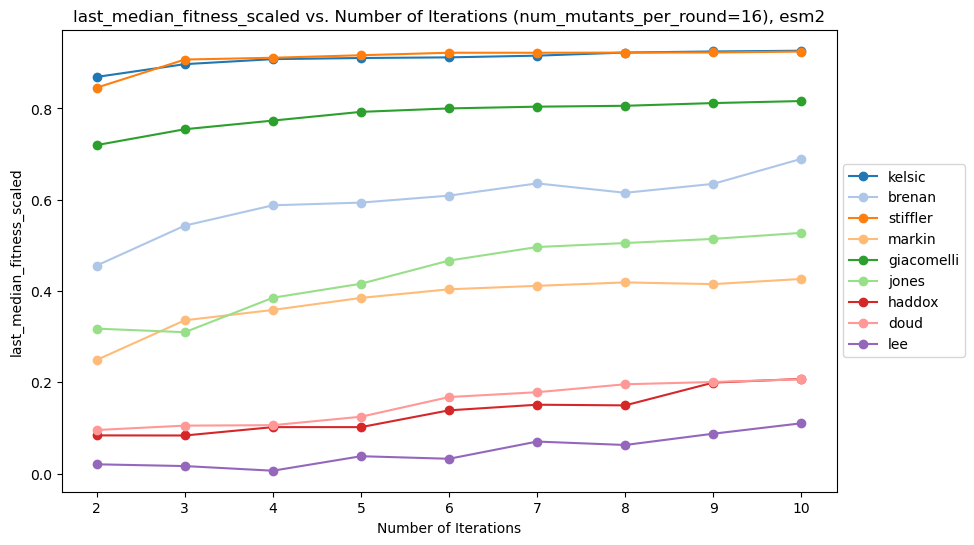

In [9]:
plot_num_iterations_vs_output(df, 'last_median_fitness_scaled', num_mutants_per_round=16)

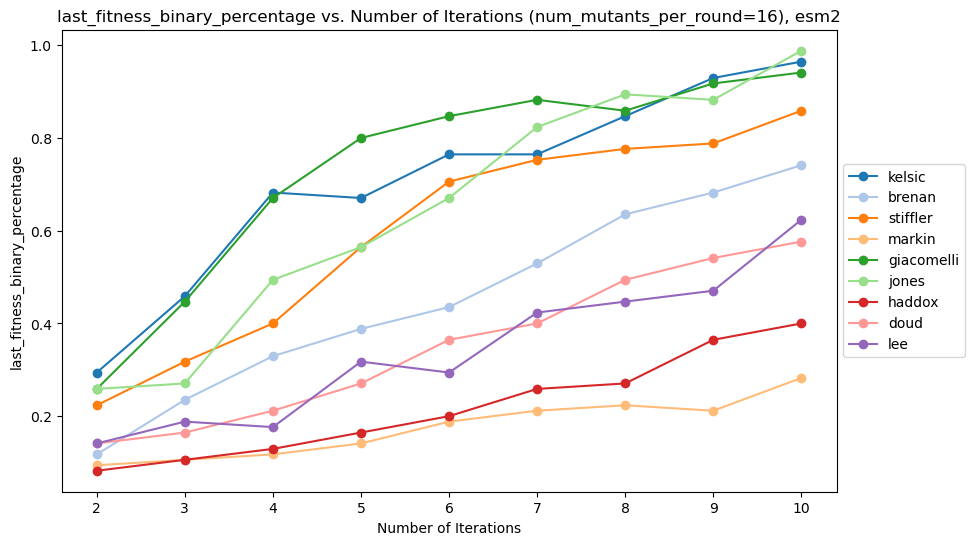

In [10]:
plot_num_iterations_vs_output(df, 'last_fitness_binary_percentage', num_mutants_per_round=16)